In [14]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar
import importlib

# math and data
import math
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import scipy.linalg
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
misc_data_path = '/glade/u/home/zcleveland/scratch/misc_data/'  # path to misc data
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated plots
scripts_main_path = '/glade/u/home/zcleveland/NAM_soil-moisture/scripts_main/'  # path to my dicts, lists, and functions

# import variable lists and dictionaries
if scripts_main_path not in sys.path:
    sys.path.insert(0, scripts_main_path)  # path to file containing these lists/dicts
if 'get_var_data' in sys.modules:
    importlib.reload(sys.modules['get_var_data'])
if 'my_functions' in sys.modules:
    importlib.reload(sys.modules['my_functions'])
if 'my_dictionaries' in sys.modules:
    importlib.reload(sys.modules['my_dictionaries'])
if 'order_years' in sys.modules:
    importlib.reload(sys.modules['order_years'])

# import common functions that I've created
from get_var_data import get_var_data, get_var_files, open_var_data, subset_var_data, time_to_year_month_avg, time_to_year_month_sum, time_to_year_month
from my_functions import month_num_to_name, ensure_var_list
from order_years import *  # order_years(var, months, **kwargs)

# import lists and dictionaries
import my_dictionaries
# my lists
sfc_instan_list = my_dictionaries.sfc_instan_list  # instantaneous surface variables
sfc_accumu_list = my_dictionaries.sfc_accumu_list  # accumulated surface variables
pl_var_list = my_dictionaries.pl_var_list  # pressure level variables
invar_var_list = my_dictionaries.invar_var_list  # invariant variables
NAM_var_list = my_dictionaries.NAM_var_list  # NAM-based variables
region_avg_list = my_dictionaries.region_avg_list  # region IDs for regional averages
flux_var_list = my_dictionaries.flux_var_list  # flux variables that need to be flipped (e.g., sensible heat so that it's positive up instead of down
vector_var_list = my_dictionaries.vector_var_list  # variables that can be turned into a vector (wind, e/n moisture transport, etc.)
misc_var_list = my_dictionaries.misc_var_list  # misc variables
# my dictionaries
var_dict = my_dictionaries.var_dict  # variables and their names
var_units = my_dictionaries.var_units  # variable units
region_avg_dict = my_dictionaries.region_avg_dict  # region IDs and names
region_avg_coords = my_dictionaries.region_avg_coords  # coordinates for regions
region_colors_dict = my_dictionaries.region_colors_dict  # colors to plot for each region

In [35]:
# define the function to calculate the regression between two variables
def main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs):
    # get kwargs
    save_png = kwargs.get('save_png', False)
    show_png = kwargs.get('show_png', False)
    overwrite_flag = kwargs.get('overwrite_flag', False)

    # make sure that if var1 or var2 are a list, they are contained in the vector_var_list
    if isinstance(var1, list) and var1 not in vector_var_list:
        raise ValueError(f"List of var1 must be an option of vector_var_list: {vector_var_list}\nvar1: {var1}")
    if isinstance(var2, list) and var2 not in vector_var_list:
        raise ValueError(f"List of var2 must be an option of vector_var_list: {vector_var_list}\nvar1: {var2}")

    # get month names for each var
    var1_month_names = month_num_to_name(ensure_var_list(var1)[0], var1_months)
    var2_month_names = month_num_to_name(ensure_var_list(var2)[0], var2_months)

    # get core and output filenames and output file paths
    fn_core, out_fn = get_out_fn(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs)
    out_fp = get_out_fp(out_fn, var1_region, var2_region, **kwargs)

    # check if the .nc file already exists for the regression
    if not os.path.exists(out_fp):
        main_regression(var1, var1_region, var1_months, var1_month_names, var2, var2_region, var2_months, var2_month_names, out_fp, **kwargs)

    else:
        print(f'.png file already exists. {out_fn}')
        if not overwrite_flag:  # only overwrite if specified by user
            print(f'overwrite_flag is False. set to True to overwrite: {out_fp}')
            if show_png:
                print('Showing saved plot . . .')
                fig_title = make_fig_title(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs)
                show_regression(out_fp, fig_title, **kwargs)
        else:
            print('overwrite_flag is True. Overwriting . . .')
            main_regression(var1, var1_region, var1_months, var1_month_names, var2, var2_region, var2_months, var2_month_names, out_fp, **kwargs)

In [36]:
# define the main function for calculating regression
def main_regression(var1, var1_region, var1_months, var1_month_names, var2, var2_region, var2_months, var2_month_names, out_fp, **kwargs):

    if isinstance(var1, list):
        u_var_data, v_var_data, var2_data, u_regression_ds, v_regression_ds = var1_vector_regression(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)
        cbar_label = make_cbar_label(var2, **kwargs)
        fig_title = make_fig_title(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs)
        plot_var1_vector_regression(u_var_data, v_var_data, var2_data, u_regression_ds, v_regression_ds, fig_title, cbar_label, out_fp, **kwargs)
    elif isinstance(var2, list):
        var1_data, u_var_data, v_var_data, u_regression_ds, v_regression_ds = var2_vector_regression(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)
        cbar_label = make_cbar_label(var2, **kwargs)
        fig_title = make_fig_title(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs)
        plot_var2_vector_regression(var1_data, u_var_data, v_var_data, u_regression_ds, v_regression_ds, fig_title, cbar_label, out_fp, **kwargs)
    else:
        var1_data, var2_data, regression_ds = no_vector_regression(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)
        cbar_label = make_cbar_label(var2, **kwargs)
        fig_title = make_fig_title(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs)
        plot_no_vector_regression(var1_data, var2_data, regression_ds, fig_title, cbar_label, out_fp, **kwargs)

In [17]:
def var1_vector_regression(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs):

    u_var, v_var = var1[0], var1[1]
    # get var data
    u_var_data = get_var_data(u_var, region=var1_region, level=kwargs.get('var1_level', None), **kwargs)
    v_var_data = get_var_data(v_var, region=var1_region, level=kwargs.get('var1_level', None), **kwargs)
    var2_data = get_var_data(var2, region=var2_region, level=kwargs.get('var2_level', None), **kwargs)

    # convert data to year, month and extract var_months
    # detrend data and average months
    if var1 not in NAM_var_list:
        u_var_data = time_to_year_month_avg(u_var_data, **kwargs).sel(month=var1_months)
        v_var_data = time_to_year_month_avg(v_var_data, **kwargs).sel(month=var1_months)
        u_var_data = apply_detrend(u_var_data, **kwargs).mean('month', skipna=True)
        v_var_data = apply_detrend(v_var_data, **kwargs).mean('month', skipna=True)
    else:
        u_var_data = apply_detrend(u_var_data, **kwargs)
        v_var_data = apply_detrend(v_var_data, **kwargs)
    if var2 not in NAM_var_list:
        var2_data = time_to_year_month_avg(var2_data, **kwargs).sel(month=var2_months)
        var2_data = apply_detrend(var2_data, **kwargs).mean('month', skipna=True)
    else:
        var2_data = apply_detrend(var2_data, **kwargs)

    # deseasonalize data if specified
    detrend_type = kwargs.get('detrend_type', 'zscore')
    if detrend_type:
        if detrend_type == 'deseasonalize':
            u_var_data = calc_deseasonalize(u_var_data, **kwargs)
            v_var_data = calc_deseasonalize(v_var_data, **kwargs)
            var2_data = calc_deseasonalize(var2_data, **kwargs)
        elif detrend_type == 'zscore':
            u_var_data = calc_zscore(u_var_data, **kwargs)
            v_var_data = calc_zscore(v_var_data, **kwargs)
            var2_data = calc_zscore(var2_data, **kwargs)
        else:
            raise ValueError(f"detrend_type currently only supports 'deseasonalize' and 'zscore'.\ndetrend_type: {detrend_type}")

    # check if var is a flux and need to be flipped (e.g., sensible heat should be pos up instead of down)
    if var2 in flux_var_list or var2 == 'onset':
        var2_data = var2_data * -1

    # apply regression to data
    u_regression_ds = apply_regression(u_var_data, var2_data, **kwargs)
    v_regression_ds = apply_regression(v_var_data, var2_data, **kwargs)
    return u_var_data, v_var_data, var2_data, u_regression_ds, v_regression_ds

In [18]:
def var2_vector_regression(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs):

    u_var, v_var = var2[0], var2[1]
    # get var data
    var1_data = get_var_data(var1, region=var1_region, level=kwargs.get('var1_level', None), **kwargs)
    u_var_data = get_var_data(u_var, region=var2_region, level=kwargs.get('var2_level', None), **kwargs)
    v_var_data = get_var_data(v_var, region=var2_region, level=kwargs.get('var2_level', None), **kwargs)

    # convert data to year, month and extract var_months
    # detrend data and average months
    if var1 not in NAM_var_list:
        var1_data = time_to_year_month_avg(var1_data, **kwargs).sel(month=var1_months)
        var1_data = apply_detrend(var1_data, **kwargs).mean('month', skipna=True)
    else:
        var1_data = apply_detrend(var1_data, **kwargs)
    if var2 not in NAM_var_list:
        u_var_data = time_to_year_month_avg(u_var_data, **kwargs).sel(month=var2_months)
        v_var_data = time_to_year_month_avg(v_var_data, **kwargs).sel(month=var2_months)
        u_var_data = apply_detrend(u_var_data, **kwargs).mean('month', skipna=True)
        v_var_data = apply_detrend(v_var_data, **kwargs).mean('month', skipna=True)
    else:
        u_var_data = apply_detrend(u_var_data, **kwargs)
        v_var_data = apply_detrend(v_var_data, **kwargs)

    # deseasonalize data if specified
    detrend_type = kwargs.get('detrend_type', 'zscore')
    if detrend_type:
        if detrend_type == 'deseasonalize':
            var1_data = calc_deseasonalize(var1_data, **kwargs)
            u_var_data = calc_deseasonalize(u_var_data, **kwargs)
            v_var_data = calc_deseasonalize(v_var_data, **kwargs)
        elif detrend_type == 'zscore':
            var1_data = calc_zscore(var1_data, **kwargs)
            u_var_data = calc_zscore(u_var_data, **kwargs)
            v_var_data = calc_zscore(v_var_data, **kwargs)
        else:
            raise ValueError(f"detrend_type currently only supports 'deseasonalize' and 'zscore'.\ndetrend_type: {detrend_type}")

    # check if var is a flux and need to be flipped (e.g., sensible heat should be pos up instead of down)
    if var1 in flux_var_list or var1 == 'onset':
        var1_data = var1_data * -1

    # apply regression to data
    u_regression_ds = apply_regression(var1_data, u_var_data, **kwargs)
    v_regression_ds = apply_regression(var1_data, v_var_data, **kwargs)
    return var1_data, u_var_data, v_var_data, u_regression_ds, v_regression_ds

In [19]:
def no_vector_regression(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs):

    # get var data
    var1_data = get_var_data(var1, region=var1_region, level=kwargs.get('var1_level', None), **kwargs)
    var2_data = get_var_data(var2, region=var2_region, level=kwargs.get('var2_level', None), **kwargs)

    # convert data to year, month and extract var_months
    # detrend data and average months
    if var1 not in NAM_var_list:
        var1_data = time_to_year_month_avg(var1_data, **kwargs).sel(month=var1_months)
        var1_data = apply_detrend(var1_data, **kwargs).mean('month', skipna=True)
    else:
        var1_data = apply_detrend(var1_data, **kwargs)
    if var2 not in NAM_var_list:
        var2_data = time_to_year_month_avg(var2_data, **kwargs).sel(month=var2_months)
        var2_data = apply_detrend(var2_data, **kwargs).mean('month', skipna=True)
    else:
        var2_data = apply_detrend(var2_data, **kwargs)

    # deseasonalize data if specified
    detrend_type = kwargs.get('detrend_type', 'zscore')
    if detrend_type:
        if detrend_type == 'deseasonalize':
            var1_data = calc_deseasonalize(var1_data, **kwargs)
            var2_data = calc_deseasonalize(var2_data, **kwargs)
        elif detrend_type == 'zscore':
            var1_data = calc_zscore(var1_data, **kwargs)
            var2_data = calc_zscore(var2_data, **kwargs)
        else:
            raise ValueError(f"detrend_type currently only supports 'deseasonalize' and 'zscore'.\ndetrend_type: {detrend_type}")

    # check if var is a flux and need to be flipped (e.g., sensible heat should be pos up instead of down)
    if var1 in flux_var_list or var1 == 'onset':
        var1_data = var1_data * -1
    if var2 in flux_var_list or var2 == 'onset':
        var2_data = var2_data * -1

    # apply regression to data
    regression_ds = apply_regression(var1_data, var2_data, **kwargs)
    return var1_data, var2_data, regression_ds

In [20]:
def check_vars_list(var1, var2, **kwargs):
    if isinstance(var1, list) and isinstance(var2, list):
        raise ValueError("Both var1 and var2 cannot be lists")
    if isinstance(var1, list):
        return var1
    elif isinstance(var2, list):
        return var2
    else:
        return None  # if neither are a list, return None

In [1]:
# define a function to make the plot title
def make_fig_title(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs):
    # get kwargs
    var1_level = kwargs.get('var1_level', '')
    var2_level = kwargs.get('var2_level', '')

    var1_parenth = [str(var1_level), str(var1_month_names), str(var1_region)]
    var2_parenth = [str(var2_level), str(var2_month_names), str(var2_region)]

    var2_title = f"{var_dict[str(var2)]} ({' '.join([i for i in var2_parenth if i != ''])})"
    var1_title = f"{var_dict[str(var1)]} ({' '.join([i for i in var1_parenth if i != ''])})"

    title = f"{var2_title}\nregressed on\n{var1_title}"
    return title


def make_cbar_label(var2, **kwargs):
    # get kwargs
    detrend_type = kwargs.get('detrend_type', 'zscore')
    if detrend_type == 'zscore':
        return 'Standard Deviation'
    else:
        return var_units[var2]

In [23]:
# define a function to open and show plots that already exists
def show_regression(filpath, fig_title, **kwargs):

    fig, ax = plt.subplots(figsize=(12,10))
    img = mpimg.imread(filpath)
    plt.imshow(img)
    plt.axis('off')
    # plt.title(fig_title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [41]:
def plot_var1_vector_regression(u_var_data, v_var_data, var2_data, u_regression_ds, v_regression_ds, fig_title, cbar_label, out_fp, **kwargs):

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(projection=projection))

    # calculate spread of variables
    u_var_min = u_var_data.min(dim=kwargs.get('time_group', 'time'), skipna=True)
    u_var_max = u_var_data.max(dim=kwargs.get('time_group', 'time'), skipna=True)
    v_var_min = v_var_data.min(dim=kwargs.get('time_group', 'time'), skipna=True)
    v_var_max = v_var_data.max(dim=kwargs.get('time_group', 'time'), skipna=True)
    var2_u_min = u_regression_ds['slope'] * u_var_min + u_regression_ds['intercept']
    var2_u_max = u_regression_ds['slope'] * u_var_max + u_regression_ds['intercept']
    var2_v_min = v_regression_ds['slope'] * v_var_min + v_regression_ds['intercept']
    var2_v_max = v_regression_ds['slope'] * v_var_max + v_regression_ds['intercept']
    var2_u_spread = var2_u_max - var2_u_min
    var2_v_spread = var2_v_max - var2_v_min

    var2_spread = np.sqrt(var2_u_spread**2 + var2_v_spread**2)
    regression_slope = np.sqrt(u_regression_ds['slope']**2 + v_regression_ds['slope']**2)

    vmin = 0
    vmax = 3
    cf_levels = np.arange(vmin, vmax + 0.25, 0.25)
    norm = plt.Normalize(vmin, vmax)
    cmap = 'Reds'

    # plot the data using contourf
    regress_cf = ax.contourf(var2_spread.longitude, var2_spread.latitude,
                              var2_spread, levels=cf_levels,
                              cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

    regress_cs = ax.contour(regression_slope.longitude, regression_slope.latitude,
                             regression_slope, levels=10, linewidths=0.5, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    lon, lat = var2_spread.longitude.values, var2_spread.latitude.values
    lons, lats = np.meshgrid(lon, lat)
    gs = 4
    ax.quiver(lons[::gs,::gs], lats[::gs,::gs], var2_u_spread[::gs,::gs], var2_v_spread[::gs,::gs], color='k', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # add colorbar, contours, and title
    plt.colorbar(regress_cf, ax=ax, label=cbar_label, pad=0.02)
    plt.clabel(regress_cs, inline=True, fontsize=8, fmt='%1.1f')
    fig.suptitle(fig_title)
    plt.tight_layout()

    if kwargs.get('save_png', False):
        plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    if kwargs.get('show_png', True):
        plt.show()
    plt.close('all')

In [42]:
def plot_var2_vector_regression(var1_data, u_var_data, v_var_data, u_regression_ds, v_regression_ds, fig_title, cbar_label, out_fp, **kwargs):

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(projection=projection))

    # calculate spread of variables
    var1_min = var1_data.min(dim=kwargs.get('time_group', 'time'), skipna=True)
    var1_max = var1_data.max(dim=kwargs.get('time_group', 'time'), skipna=True)
    u_var_min = u_regression_ds['slope'] * var1_min + u_regression_ds['intercept']
    u_var_max = u_regression_ds['slope'] * var1_max + u_regression_ds['intercept']
    v_var_min = v_regression_ds['slope'] * var1_min + v_regression_ds['intercept']
    v_var_max = v_regression_ds['slope'] * var1_max + v_regression_ds['intercept']
    var2_u_spread = u_var_max - u_var_min
    var2_v_spread = v_var_max - v_var_min

    var2_spread = np.sqrt(var2_u_spread**2 + var2_v_spread**2)
    regression_slope = np.sqrt(u_regression_ds['slope']**2 + v_regression_ds['slope']**2)

    vmin = 0
    vmax = 3
    cf_levels = np.arange(vmin, vmax + 0.25, 0.25)
    norm = plt.Normalize(vmin, vmax)
    cmap = 'Reds'

    # plot the data using contourf
    regress_cf = ax.contourf(var2_spread.longitude, var2_spread.latitude,
                              var2_spread, levels=cf_levels,
                              cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

    regress_cs = ax.contour(regression_slope.longitude, regression_slope.latitude,
                             regression_slope, levels=10, linewidths=0.5, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    lon, lat = var2_spread.longitude.values, var2_spread.latitude.values
    lons, lats = np.meshgrid(lon, lat)
    gs = 4
    ax.quiver(lons[::gs,::gs], lats[::gs,::gs], var2_u_spread[::gs,::gs], var2_v_spread[::gs,::gs], color='k', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # add colorbar, contours, and title
    plt.colorbar(regress_cf, ax=ax, label=cbar_label, pad=0.02)
    plt.clabel(regress_cs, inline=True, fontsize=8, fmt='%1.1f')
    fig.suptitle(fig_title)
    plt.tight_layout()

    if kwargs.get('save_png', False):
        plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    if kwargs.get('show_png', True):
        plt.show()
    plt.close('all')

In [43]:
# define a function to plot the regression data
def plot_no_vector_regression(var1_data, var2_data, regression_ds, fig_title, cbar_label, out_fp, **kwargs):

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(projection=projection))

    # calculate spread of variables
    var1_min = var1_data.min(dim=kwargs.get('time_group', 'time'), skipna=True)
    var1_max = var1_data.max(dim=kwargs.get('time_group', 'time'), skipna=True)
    var2_min = regression_ds['slope'] * var1_min + regression_ds['intercept']
    var2_max = regression_ds['slope'] * var1_max + regression_ds['intercept']
    var2_spread = var2_max - var2_min
    regression_slope = regression_ds['slope']

    # create contour levels and hatches for plotting
    vmin = -3
    vmax = 3
    cf_levels = np.arange(vmin, vmax + 0.25, 0.25)
    cmap = 'RdBu_r'
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # plot the data using contourf
    regress_cf = plt.contourf(var2_spread.longitude, var2_spread.latitude,
                              var2_spread, levels=cf_levels,
                              cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

    regress_cs = plt.contour(regression_slope.longitude, regression_slope.latitude,
                             regression_slope, levels=10, linewidths=0.5, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # add colorbar, contours, and title
    plt.colorbar(regress_cf, ax=ax, label=cbar_label, pad=0.02)
    plt.clabel(regress_cs, inline=True, fontsize=8, fmt='%1.1f')
    fig.suptitle(fig_title)
    plt.tight_layout()

    if kwargs.get('save_png', False):
        plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    if kwargs.get('show_png', True):
        plt.show()
    plt.close('all')

In [27]:
# define a function to create the output filenames
def get_out_fn(var1, var1_region, var1_month_names, var2, var2_region, var2_month_names, **kwargs):

    # get optional arguments for naming
    var1_level = kwargs.get('var1_level', '')
    var2_level = kwargs.get('var2_level', '')
    detrend_type = kwargs.get('detrend_type', 'zscore')

    var1_str = '-'.join(ensure_var_list(var1))
    var2_str = '-'.join(ensure_var_list(var2))

    # create core of output file name
    fn_list = [str(var1_str), str(var1_level), str(var1_month_names), str(var1_region),
               str(var2_str), str(var2_level), str(var2_month_names), str(var2_region),
               str(detrend_type)]
    fn_core = '_'.join([i for i in fn_list if i != ''])
    out_fn = f'regress_{fn_core}.png'
    return fn_core, out_fn

In [28]:
# define a function to create the output filepaths
def get_out_fp(out_fn, var1_region, var2_region, **kwargs):

    # check region for where to save .nc and .png files
    if (var1_region == 'global') or (var2_region == 'global'):
        return os.path.join(plot_out_path, 'regressions/global', out_fn)
    elif (var1_region == 'dsw') or (var2_region == 'dsw'):
        return os.path.join(plot_out_path, 'regressions/dsw', out_fn)
    elif (var1_region in region_avg_list) and (var2_region in region_avg_list):
        return os.path.join(plot_out_path, 'regressions/regions', out_fn)
    else:
        raise ValueError(f'var1_region or var2_region contain an error. var1_region: {var1_region}\tvar2_region: {var2_region}')

In [29]:
# define a function to regress data
def regress_data(arr1, arr2):
    # mask out nan values
    mask = np.isfinite(arr1) & np.isfinite(arr2)
    arr1_mask = arr1[mask]
    arr2_mask = arr2[mask]

    # check that there are enough data points and not all x values are identical
    if len(np.unique(arr1_mask)) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    else:  # compute linear regression
        res = sp.stats.linregress(arr1_mask, arr2_mask)
        return res.slope, res.intercept, res.rvalue, res.pvalue, res.stderr, res.intercept_stderr


# define a function to mask data for detrending or correlating
def apply_regression(da1, da2, **kwargs):
    input_dims = kwargs.get('time_group', 'year')
    da1.load()
    da2.load()

    result = xr.apply_ufunc(
        regress_data, da1, da2,
        input_core_dims=[[input_dims], [input_dims]],
        output_core_dims=[[], [], [], [], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float, float, float, float, float]
    )
    regression_ds = xr.Dataset({
        'slope': result[0],
        'intercept': result[1],
        'rvalue': result[2],
        'pvalue': result[3],
        'stderr': result[4],
        'intercept_stderr': result[5]
    })

    return regression_ds

In [30]:
# define a function to detrend the data
def detrend_data(arr):
    # set up x array for the years
    arr_time = np.arange(0,len(arr))

    # mask out nan values
    mask = np.isfinite(arr)
    arr_time_mask = arr_time[mask]
    arr_mask = arr[mask]

    # make sure the array is not full of non-finite values
    if len(arr_mask) == 0:
        arr_detrend = np.empty(len(arr))
        arr_detrend[:] = np.nan
    else:  # compute linear regression
        result = sp.stats.linregress(arr_time_mask, arr_mask)
        m, b = result.slope, result.intercept

        # detrend the data
        arr_detrend = arr - (m*arr_time + b)

    return arr_detrend


# define a function to mask data for detrending or correlating
def apply_detrend(da, **kwargs):
    input_dims = kwargs.get('time_group', 'year')
    da.load()

    da_detrend = xr.apply_ufunc(
        detrend_data, da,
        input_core_dims=[[input_dims]],
        output_core_dims=[[input_dims]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[da.dtype]
    )

    return da_detrend

In [31]:
# define a function to zscore a variable
def calc_zscore(da, **kwargs):
    # assuming da is input with dimensions (year: , ...)
    da_mean = da.mean(dim='year', skipna=True)
    da_std = da.std(dim='year', skipna=True)
    da_zscore = (da - da_mean) / da_std

    return da_zscore

In [32]:
# define a function to deseasonalize the data
def calc_deseasonalize(da, **kwargs):
    # assuming da is input with dimensions (year: , ...)
    da_mean = da.mean(dim='year', skipna=True)
    da_deseasonalized = da - da_mean

    return da_deseasonalized

In [33]:
def time_to_year_month_avg(ds, **kwargs):
    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)

    # make a pandas MultiIndex that is years x months
    midx = pd.MultiIndex.from_product([years, months], names=("year","month"))
    ds_temp = ds.resample(time='1M').mean(dim='time')

    return ds_temp.assign_coords({'time':midx}).unstack()

In [ ]:
# test cell to copmute and plot regression data
# required arguments
var1 = ['viwve', 'viwvn']
var1_months = [6, 7]
var1_region = 'dsw'
var2 = 'length'
var2_months = [6]
var2_region = 'MeNmAz'
# optional variable arguments
var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}
# other optional arguments
other_kwargs = {
    'detrend_type': 'zscore',
    'time_group': 'year',
    # 'dim_means': [],
    'show_png': True,
    'save_png': False,
    'save_nc': False,
    'overwrite_flag': True,
}
if __name__ == '__main__':
    kwargs = other_kwargs.copy()
    if var1 in pl_var_list:
        kwargs.update({'var1_level': var_kwargs['var1_level']})
    if var2 in pl_var_list:
        kwargs.update({'var2_level': var_kwargs['var2_level']})
    main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)

.png file already exists. regress_onset_dsw_precipitation_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


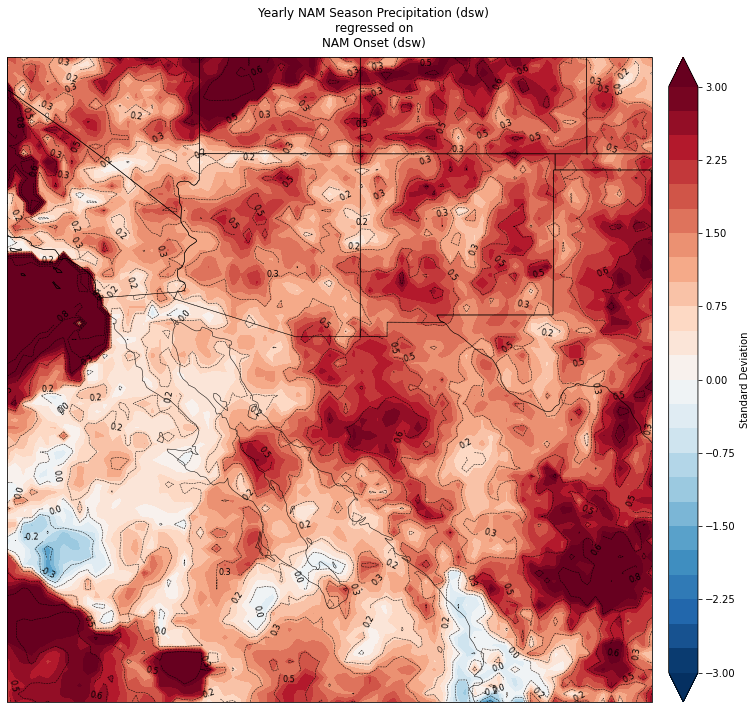

.png file already exists. regress_onset_dsw_tp_JJAS_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


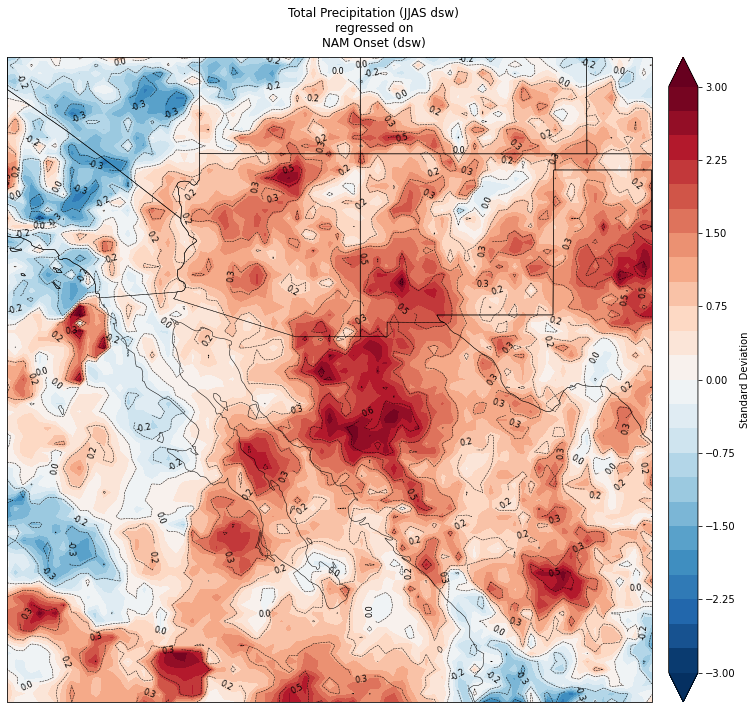

.png file already exists. regress_retreat_dsw_precipitation_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


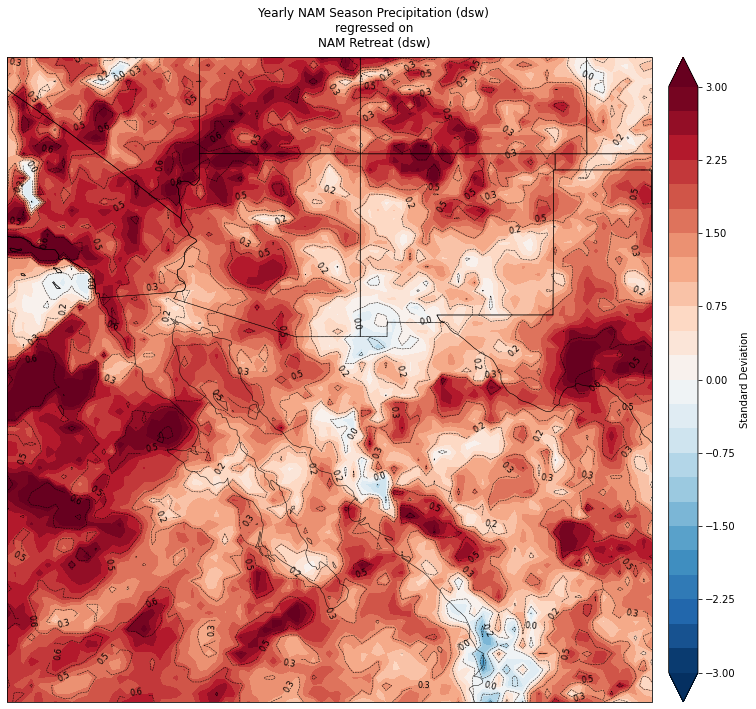

.png file already exists. regress_retreat_dsw_tp_JJAS_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


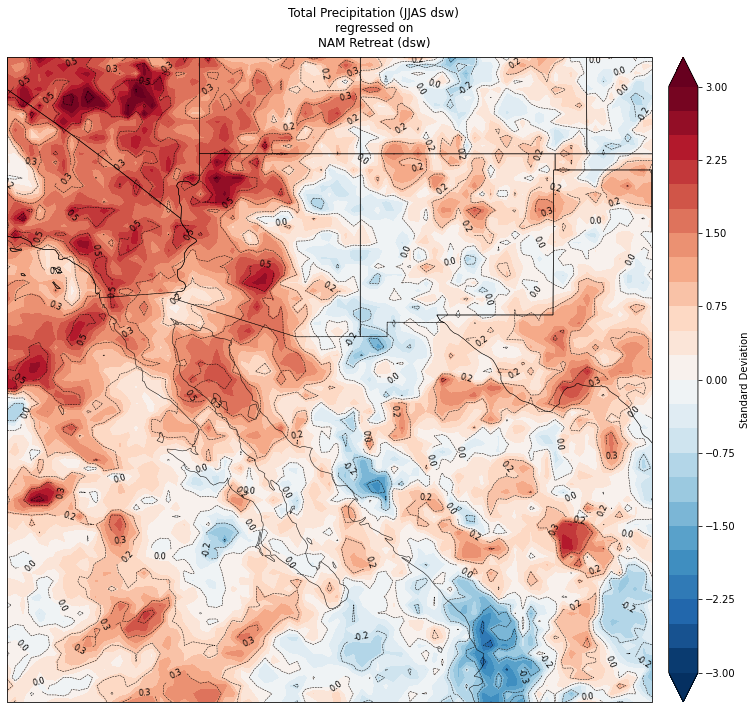

.png file already exists. regress_length_dsw_precipitation_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


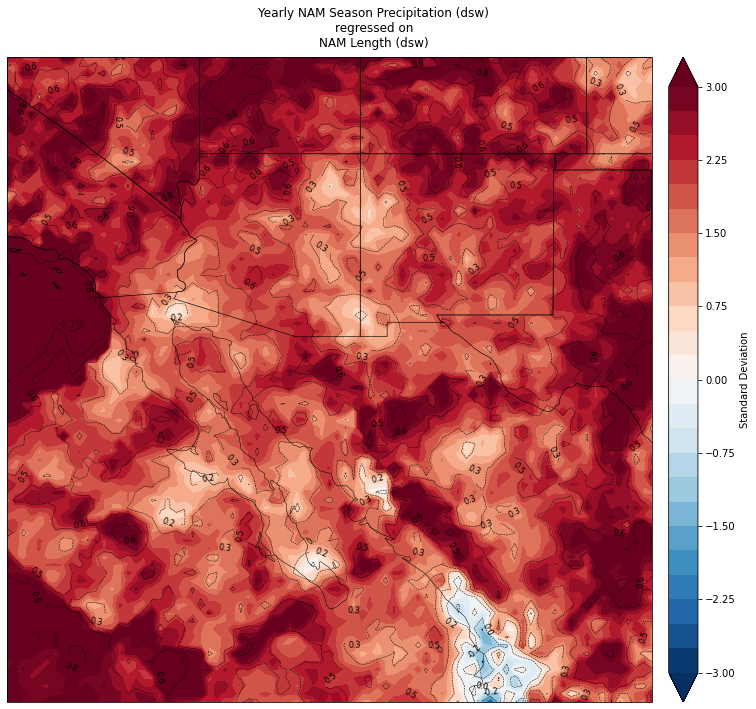

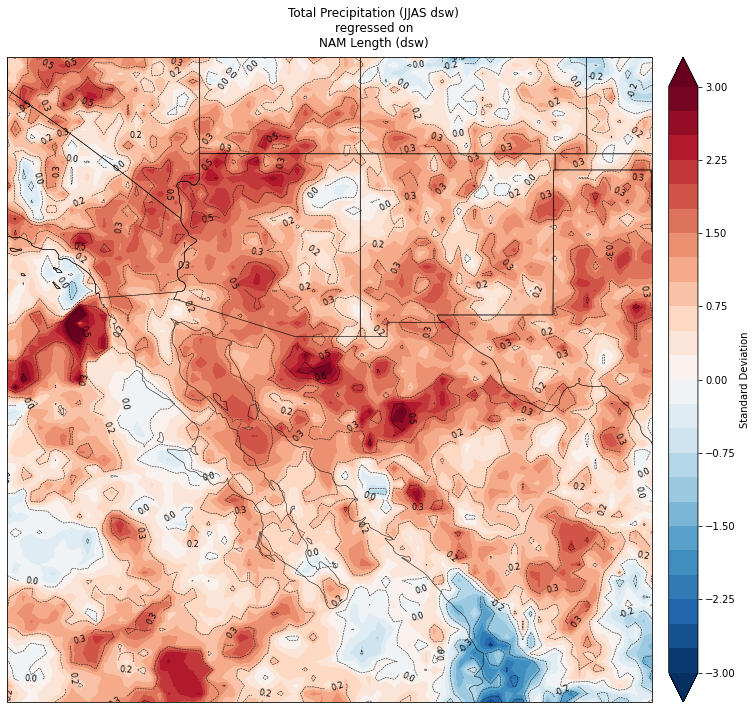

.png file already exists. regress_viwve-viwvn_MJ_dsw_onset_MeNmAz_zscore.png
overwrite_flag is True. Overwriting . . .


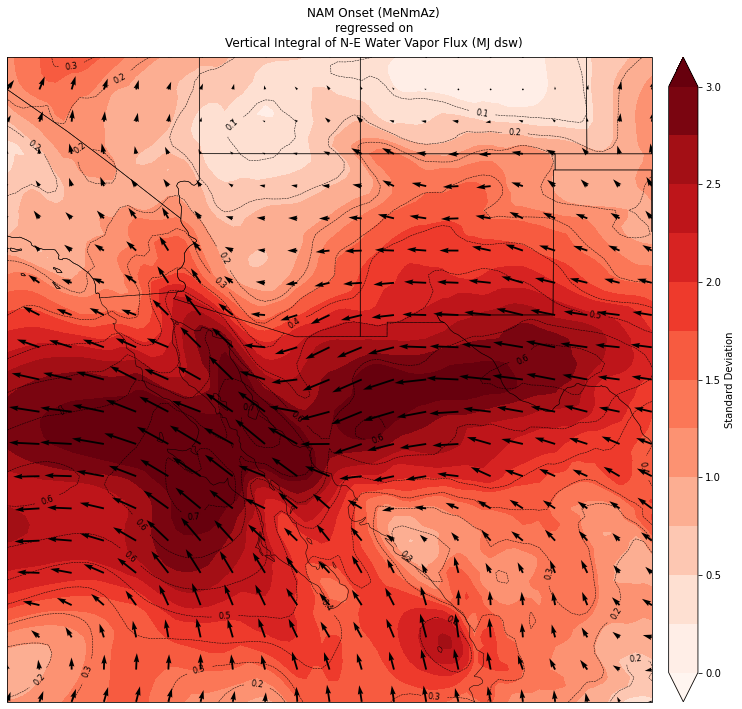

.png file already exists. regress_viwve-viwvn_JA_dsw_retreat_MeNmAz_zscore.png
overwrite_flag is True. Overwriting . . .


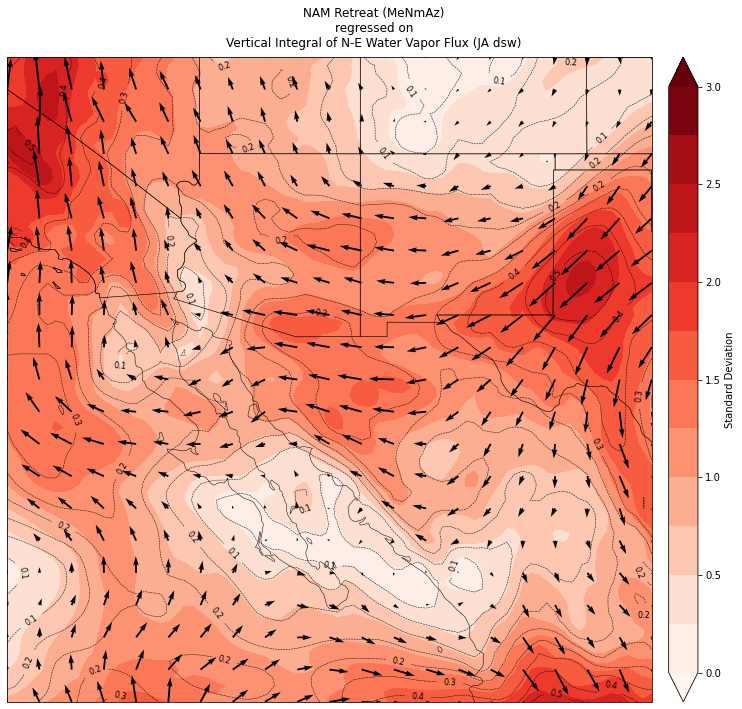

.png file already exists. regress_viwve-viwvn_JJ_dsw_length_MeNmAz_zscore.png
overwrite_flag is True. Overwriting . . .


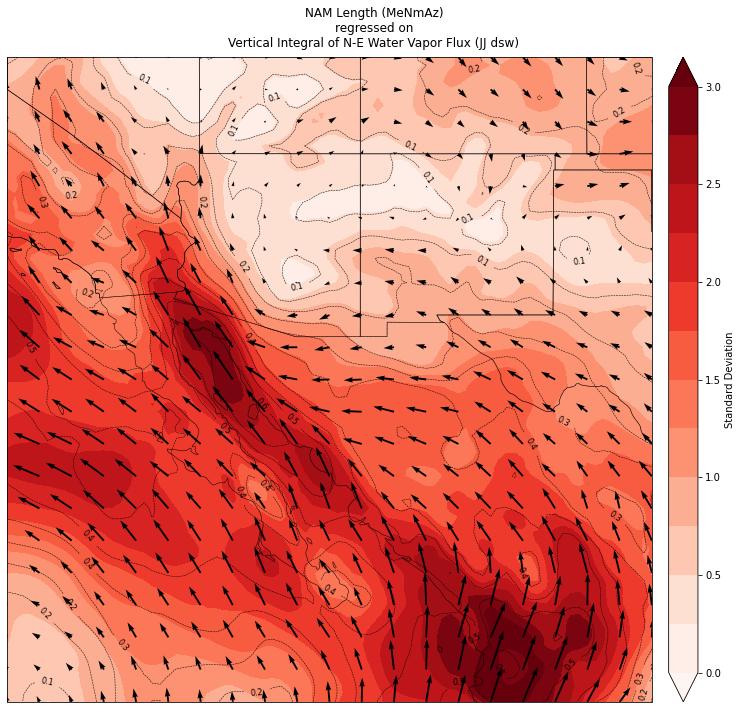

.png file already exists. regress_z_thick_1000-500_June_cp_viwve-viwvn_JJ_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


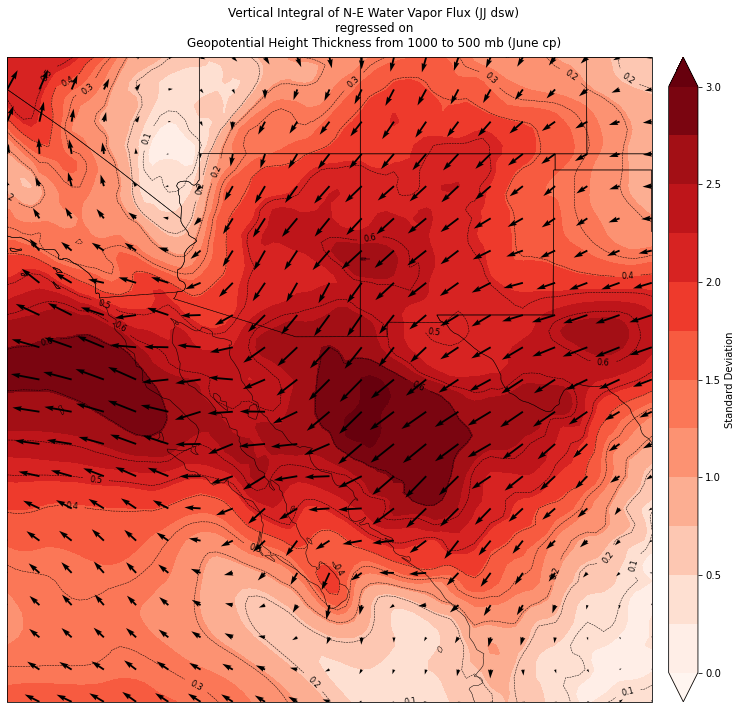

.png file already exists. regress_sshf_AMJ_cp_z_thick_1000-500_June_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


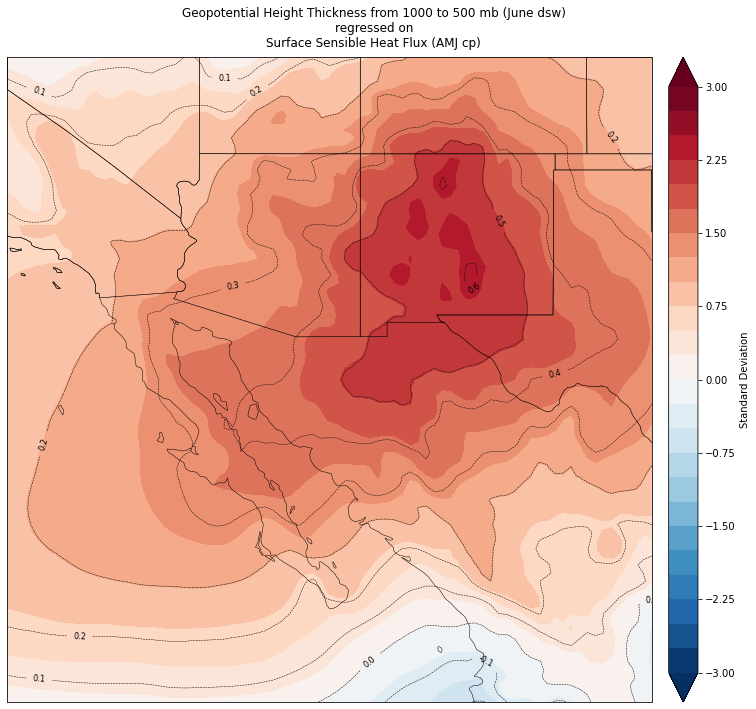

.png file already exists. regress_slhf_AMJ_cp_z_thick_1000-500_June_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


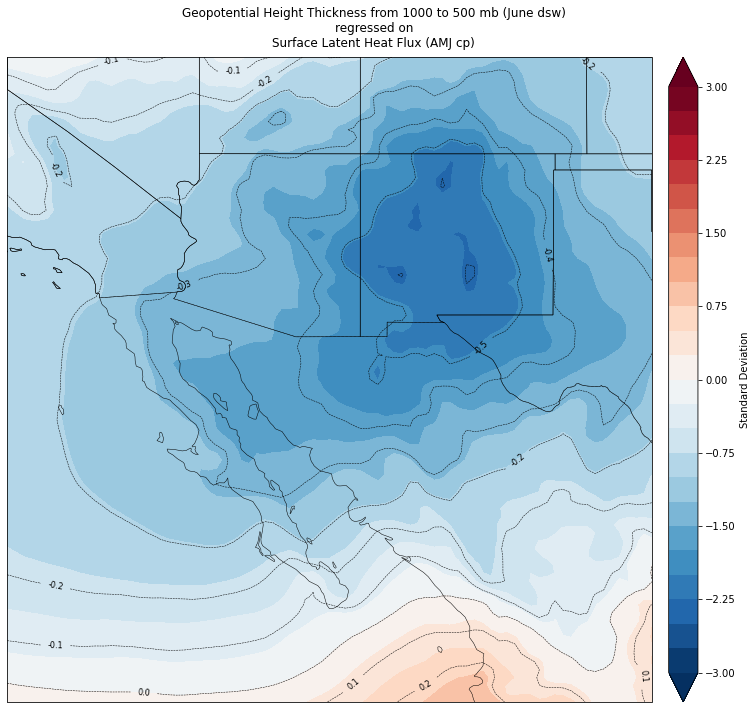

.png file already exists. regress_sd_MAM_cp_sshf_AMJ_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


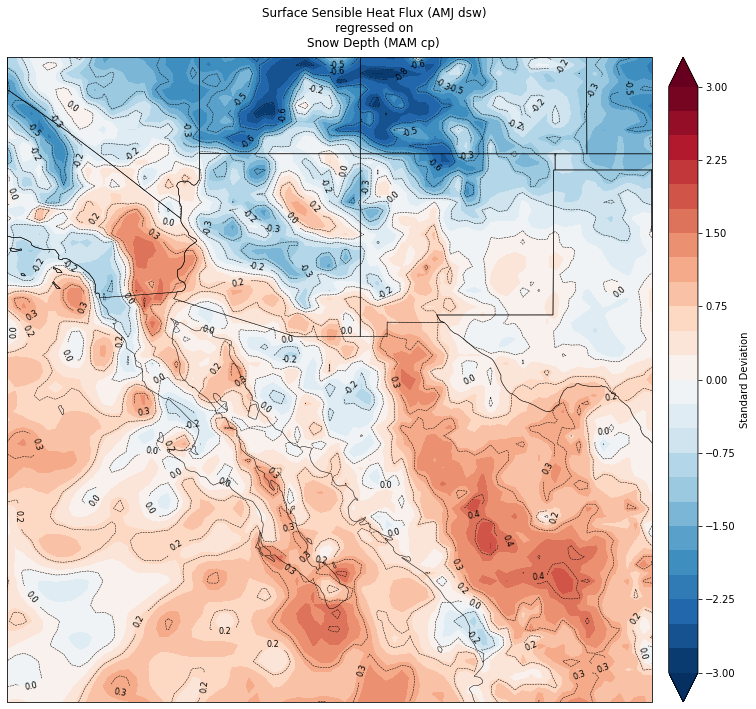

.png file already exists. regress_sd_MAM_cp_slhf_AMJ_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


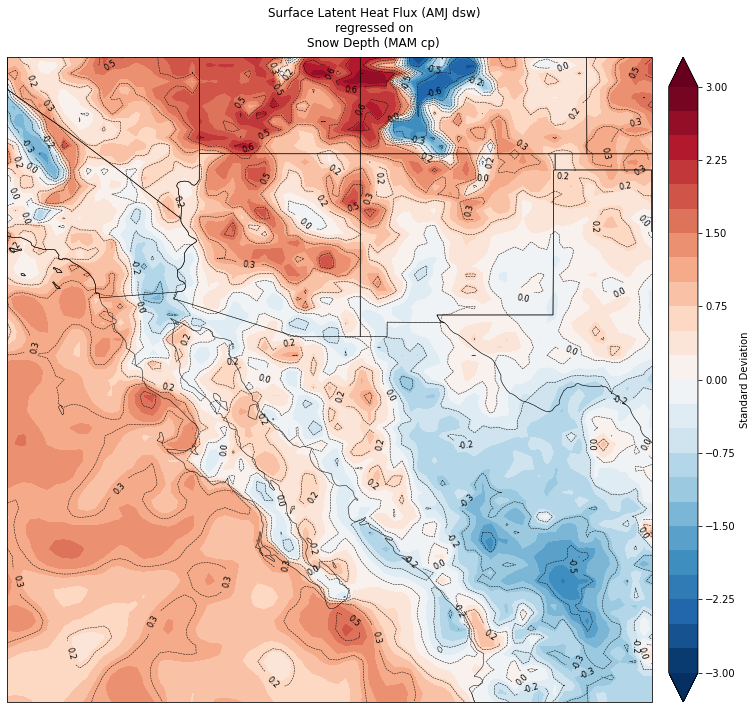

.png file already exists. regress_swvl1_MAM_cp_sshf_AMJ_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


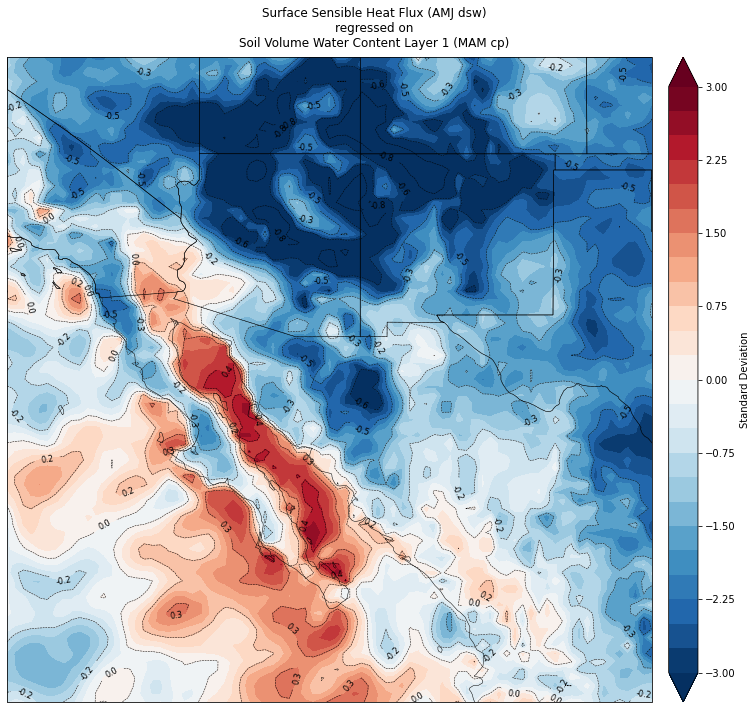

.png file already exists. regress_swvl1_MAM_cp_slhf_AMJ_dsw_zscore.png
overwrite_flag is True. Overwriting . . .


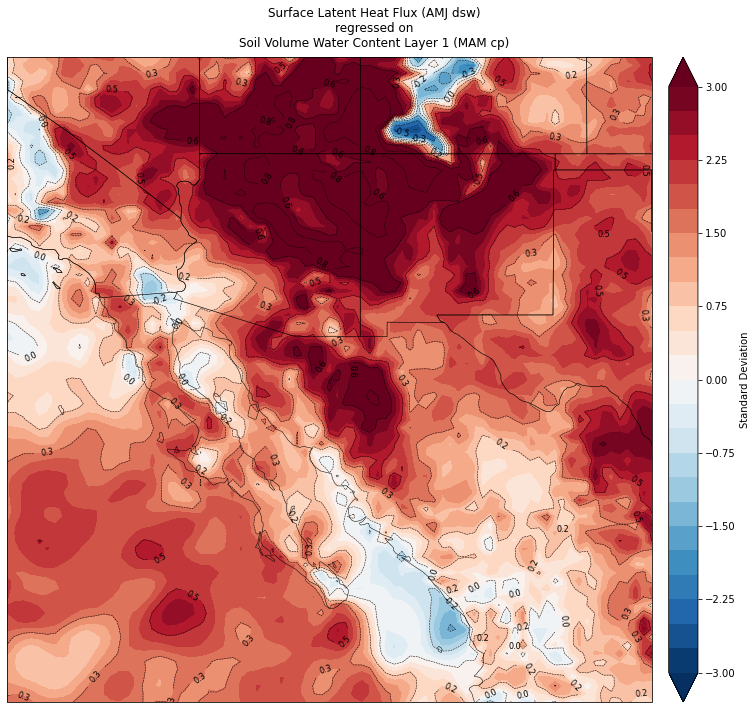

In [46]:
# test cell to copmute and plot regression data
# required arguments
var1 = [
    'onset',
    'onset',
    'retreat',
    'retreat',
    'length',
    'length',
    ['viwve', 'viwvn'],
    ['viwve', 'viwvn'],
    ['viwve', 'viwvn'],
    'z_thick_1000-500',
    'sshf',
    'slhf',
    'sd',
    'sd',
    'swvl1',
    'swvl1',
]
var1_months = [
    [6],
    [6],
    [6],
    [6],
    [6],
    [6],
    [5, 6],
    [7, 8],
    [6, 7],
    [6],
    [4, 5, 6],
    [4, 5, 6],
    [3, 4, 5],
    [3, 4, 5],
    [3, 4, 5],
    [3, 4, 5],
]
var1_region = [
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'cp',
    'cp',
    'cp',
    'cp',
    'cp',
    'cp',
    'cp',
]
var2 = [
    'precipitation',
    'tp',
    'precipitation',
    'tp',
    'precipitation',
    'tp',
    'onset',
    'retreat',
    'length',
    ['viwve', 'viwvn'],
    'z_thick_1000-500',
    'z_thick_1000-500',
    'sshf',
    'slhf',
    'sshf',
    'slhf',
]
var2_months = [
    [6, 7, 8, 9],
    [6, 7, 8, 9],
    [6, 7, 8, 9],
    [6, 7, 8, 9],
    [6, 7, 8, 9],
    [6, 7, 8, 9],
    [6],
    [6],
    [6],
    [6, 7],
    [6],
    [6],
    [4, 5, 6],
    [4, 5, 6],
    [4, 5, 6],
    [4, 5, 6],
]
var2_region = [
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'MeNmAz',
    'MeNmAz',
    'MeNmAz',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
    'dsw',
]
# optional variable arguments
var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}
# other optional arguments
other_kwargs = {
    'detrend_type': 'zscore',
    'time_group': 'year',
    # 'dim_means': [],
    'show_png': True,
    'save_png': True,
    'save_nc': False,
    'overwrite_flag': True,
}
if __name__ == '__main__':
    for i in range(len(var1)):
        kwargs = other_kwargs.copy()
        if var1[i] in pl_var_list:
            kwargs.update({'var1_level': var_kwargs['var1_level']})
        if var2[i] in pl_var_list:
            kwargs.update({'var2_level': var_kwargs['var2_level']})
        main(var1[i], var1_region[i], var1_months[i], var2[i], var2_region[i], var2_months[i], **kwargs)

In [ ]:
# # test cell to compare detrend types
# # required arguments
# var1 = 'nino-3'
# var1_months = [3, 4, 5]
# var1_region = 'dsw'
# var2 = 'precipitation'
# var2_months = [6, 7, 8, 9, 10]
# var2_region = 'dsw'

# # optional variable arguments
# var_kwargs = {
#     'var1_level': 500,
#     'var2_level': 500,
# }

# # other optional arguments
# other_kwargs = {
#     'detrend_type': '',
#     'time_group': 'year',
#     # 'dim_means': [],
#     'show_png': True,
#     'save_png': False,
#     'save_nc': False,
#     'overwrite_flag': False,
# }

# detrend_types = ['', 'deseasonalize', 'zscore']

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         kwargs = other_kwargs.copy()
#         kwargs['detrend_type'] = detrend_type

#         if var1 in pl_var_list:
#             kwargs.update({'var1_level': var_kwargs['var1_level']})
#         if var2 in pl_var_list:
#             kwargs.update({'var2_level': var_kwargs['var2_level']})

#         main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)

In [ ]:
# optional variable arguments
var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}

# other optional arguments
other_kwargs = {
    'detrend_type': '',
    'time_group': 'year',
    # 'dim_means': [],
    'show_png': True,
    'save_png': False,
    'save_nc': False,
    'overwrite_flag': False,
}

detrend_types = ['', 'deseasonalize', 'zscore']

In [ ]:
# # cell to copmute and plot regression data
# # required inputs
# var1_list = ['stl1', 'sd', 'swvl1', 'sstk']
# var1_region = 'cp'
# var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

# var2_list = ['sshf', 'slhf']
# var2_region = 'dsw'
# var2_months = [6, 7, 8]

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         for var1 in var1_list:
#             for var1_months in var1_months_list:
#                 for var2 in var2_list:
#                     kwargs = other_kwargs.copy()
#                     kwargs['detrend_type'] = detrend_type
#                     if var1 in pl_var_list:
#                         kwargs.update({'var1_level': var_kwargs['var1_level']})
#                     if var2 in pl_var_list:
#                         kwargs.update({'var2_level': var_kwargs['var2_level']})

#                     print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
#                     if var1 == 'sstk':
#                         main(var1, var1_months, 'baja', var2, var2_region, var2_months, **kwargs)
#                     else:
#                         main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)

In [ ]:
# cell to copmute and plot regression data
# required inputs
var1_list = ['stl1', 'sstk', 'sshf', 'slhf', 'sd', 'swvl1', 'nino-3']
var1_region = 'cp'
var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

var2_list = ['z_height', 'z_thick_1000-500', 'msl', 'tp', 'onset', 'retreat', 'length', 'precipitation', 'precipitation-rate']
var2_region = 'dsw'
var2_months = [6, 7, 8]

if __name__ == '__main__':
    for detrend_type in detrend_types:
        for var1 in var1_list:
            for var1_months in var1_months_list:
                for var2 in var2_list:
                    kwargs = other_kwargs.copy()
                    kwargs['detrend_type'] = detrend_type
                    if var1 in pl_var_list:
                        kwargs.update({'var1_level': var_kwargs['var1_level']})
                    if var2 in pl_var_list:
                        kwargs.update({'var2_level': var_kwargs['var2_level']})

                    print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
                    if var1 == 'sstk':
                        main(var1, var1_months, 'baja', var2, var2_region, var2_months, **kwargs)
                    else:
                        main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)

In [ ]:
# cell to copmute and plot regression data
# required inputs
var1_list = ['z_height', 'z_thick_1000-500', 'msl', 'nino-3']
var1_region = 'cp'
var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

var2_list = ['tp', 'onset', 'retreat', 'length', 'precipitation', 'precipitation-rate']
var2_region = 'dsw'
var2_months = [6, 7, 8]

if __name__ == '__main__':
    for detrend_type in detrend_types:
        for var1 in var1_list:
            for var1_months in var1_months_list:
                for var2 in var2_list:
                    kwargs = other_kwargs.copy()
                    kwargs['detrend_type'] = detrend_type
                    if var1 in pl_var_list:
                        kwargs.update({'var1_level': var_kwargs['var1_level']})
                    if var2 in pl_var_list:
                        kwargs.update({'var2_level': var_kwargs['var2_level']})

                    print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
                    if var1 == 'sstk':
                        main(var1, var1_months, 'baja', var2, var2_region, var2_months, **kwargs)
                    else:
                        main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)

In [ ]:
# # cell to copmute and plot regression data
# # required inputs
# var1_list = ['onset', 'retreat', 'length']
# var1_region = 'cp'
# var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

# var2_list = ['tp', 'precipitation', 'precipitation-rate']
# var2_region = 'dsw'
# var2_months = [6, 7, 8]

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         for var1 in var1_list:
#             for var1_months in var1_months_list:
#                 for var2 in var2_list:
#                     kwargs = other_kwargs.copy()
#                     kwargs['detrend_type'] = detrend_type
#                     if var1 in pl_var_list:
#                         kwargs.update({'var1_level': var_kwargs['var1_level']})
#                     if var2 in pl_var_list:
#                         kwargs.update({'var2_level': var_kwargs['var2_level']})

#                     print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
#                     if var1 == 'sstk':
#                         main(var1, var1_months, 'baja', var2, var2_region, var2_months, **kwargs)
#                     else:
#                         main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)

In [ ]:
# # cell to copmute and plot regression data
# # required inputs
# var1_list = ['onset', 'retreat', 'length']
# var1_region = 'dsw'
# var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

# var2_list = ['tp', 'precipitation', 'precipitation-rate']
# var2_region = 'dsw'
# var2_months = [6, 7, 8]

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         for var1 in var1_list:
#             for var1_months in var1_months_list:
#                 for var2 in var2_list:
#                     kwargs = other_kwargs.copy()
#                     kwargs['detrend_type'] = detrend_type
#                     if var1 in pl_var_list:
#                         kwargs.update({'var1_level': var_kwargs['var1_level']})
#                     if var2 in pl_var_list:
#                         kwargs.update({'var2_level': var_kwargs['var2_level']})

#                     print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
#                     if var1 == 'sstk':
#                         main(var1, var1_months, 'baja', var2, var2_region, var2_months, **kwargs)
#                     else:
#                         main(var1, var1_region, var1_months, var2, var2_region, var2_months, **kwargs)